In [2]:
import os, sys, importlib
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.data_processing import clean_dir, save_audio_segments_to_disk, calculate_class_totals
from utils.data_extraction import load_audio_files, extract_balanced_segments

importlib.reload(sys.modules['utils.data_processing'])
importlib.reload(sys.modules['utils.data_extraction'])

from utils.data_processing import clean_dir, save_audio_segments_to_disk, calculate_class_totals
from utils.data_extraction import load_audio_files, extract_balanced_segments

c:\Users\manue\miniconda3\envs\birds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
CLASS_CAP = 100
SEG_LENGTH = 3.0  # seconds
THRESH = 0.75  # energy
CUT_TYPE = 'rms' # 'rms', 'peaks', 'entropy', 'filter', 'none'

In [4]:
# Define Paths
audios_dir = os.path.join('..', 'database', 'audio', 'dev')
dev_df = pd.read_csv(os.path.join('..', 'database', 'meta', 'dev_data.csv'))

# Output directories for extracted segments
segments_output_dir = os.path.join('..', 'database', 'audio_segments')
segments_csv_path = os.path.join('..', 'database', 'meta', 'audio_segments.csv')

# Get the files
audio_files = load_audio_files(dev_df, audios_dir, sr=32000, segment_sec=SEG_LENGTH, thresh_factor=THRESH)

In [5]:
class_segs = calculate_class_totals(audio_files)
segments = extract_balanced_segments(audio_files, cap_per_class=CLASS_CAP, segment_sec=SEG_LENGTH, sr=32000, class_total_segments=class_segs, cutoff_type=CUT_TYPE)
print(f"Extracted {len(segments)} segments total")

Extracting segments (RMS Energy): 100%|██████████| 876/876 [00:00<00:00, 3516.54it/s]

Extracted 3702 segments total


In [6]:
# Clan & Save
clean_dir(segments_output_dir)

print("Saving audio segments to disk...")
segments_df = save_audio_segments_to_disk(segments, segments_output_dir)
segments_df.to_csv(segments_csv_path, index=False)

print(f"Saved {len(segments_df)} audio segments to {segments_output_dir}")
print(f"Metadata saved to {segments_csv_path}")

Resetting ..\database\audio_segments directory...
Saving audio segments to disk...
Saved 3702 audio segments to ..\database\audio_segments
Metadata saved to ..\database\meta\audio_segments.csv


In [7]:
# Check for repeated values in segments_df 'filename' column
filename_counts = segments_df['filename'].value_counts()
duplicates = filename_counts[filename_counts > 1]

if len(duplicates) > 0:
    print(f"Found {len(duplicates)} repeated filenames:")
    print(duplicates)
else:
    print("No repeated filenames found")

print(f"\nTotal unique filenames: {segments_df['filename'].nunique()}")
print(f"Total rows: {len(segments_df)}")

No repeated filenames found

Total unique filenames: 3702
Total rows: 3702


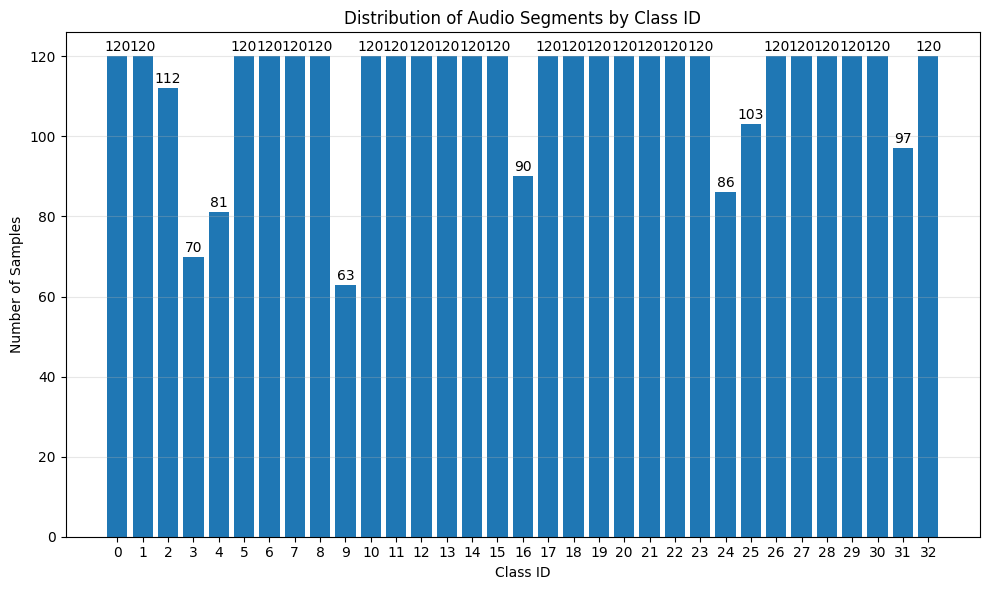

Class distribution:
Class 0: 120 samples
Class 1: 120 samples
Class 2: 112 samples
Class 3: 70 samples
Class 4: 81 samples
Class 5: 120 samples
Class 6: 120 samples
Class 7: 120 samples
Class 8: 120 samples
Class 9: 63 samples
Class 10: 120 samples
Class 11: 120 samples
Class 12: 120 samples
Class 13: 120 samples
Class 14: 120 samples
Class 15: 120 samples
Class 16: 90 samples
Class 17: 120 samples
Class 18: 120 samples
Class 19: 120 samples
Class 20: 120 samples
Class 21: 120 samples
Class 22: 120 samples
Class 23: 120 samples
Class 24: 86 samples
Class 25: 103 samples
Class 26: 120 samples
Class 27: 120 samples
Class 28: 120 samples
Class 29: 120 samples
Class 30: 120 samples
Class 31: 97 samples
Class 32: 120 samples


In [8]:
# Create histogram showing amount of samples for each class_id
class_counts = segments_df['class_id'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Distribution of Audio Segments by Class ID')
plt.xticks(class_counts.index)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(class_counts.values):
    plt.text(class_counts.index[i], v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Class distribution:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} samples")